In [1]:
# Se llaman las librerías a utilizar
import matplotlib.pyplot as plt
%matplotlib
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
from datetime import datetime
from pyproj import Proj

# Converts the CPT file to be used in Python
cpt = loadCPT('IR4AVHRR6.cpt')
# Makes a linear interpolation with the CPT file
cpt_convert = LinearSegmentedColormap('cpt', cpt)

Using matplotlib backend: Qt5Agg


In [31]:
#reflectance(radiancia, numero de banda): convierte la radiancia a reflectancia las bandas 1-6 de GOES 16
def reflectance(radiance, band):
    Esun_dict = {1:726.721072,2:663.274497,3:441.868715,4:679.143879,5:634.454241,6:381.148813}
    Esun = Esun_dict[band]
    d2 = 0.3
    refl = (radiance * np.pi * d2) / Esun
    refl = np.maximum(refl, 0.0)
    refl = np.minimum(refl, 1.0)
    return refl

# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [3]:
# Se establecen las rutas de los archivos (Editar a modo)
ruta = '/Users/Carlos/Desktop/Descargas GOES R/Saharan dust 20180628/Conus/L1 Radiances/'

Ch1_pth = ruta+"OR_ABI-L1b-RadC-M3C01_G16_s20181791502192_e20181791504565_c20181791505014.nc"
Ch2_pth = ruta+"OR_ABI-L1b-RadC-M3C02_G16_s20181791502192_e20181791504565_c20181791505011.nc"
Ch3_pth = ruta+"OR_ABI-L1b-RadC-M3C03_G16_s20181791502192_e20181791504565_c20181791505015.nc"
Ch4_pth = ruta+"OR_ABI-L1b-RadC-M3C04_G16_s20181791502192_e20181791504565_c20181791505009.nc"
Ch5_pth = ruta+"OR_ABI-L1b-RadC-M3C05_G16_s20181791502192_e20181791504565_c20181791505023.nc"

# Search for the Scan Start in the file name
Start = (Ch2_pth[Ch2_pth.find("_s")+2:Ch2_pth.find("_e")-1])
End = (Ch2_pth[Ch2_pth.find("_e")+2:Ch2_pth.find("_c")-1])

# Format the "Observation Start" string
datetime_start = datetime.strptime(Start,'%Y%j%H%M%S')
datetime_end = datetime.strptime(End,'%Y%j%H%M%S')
print(datetime_start)
print(datetime_end)

2018-06-28 15:02:19
2018-06-28 15:04:56


### Primero una imágen GEOCOLOR/True Color


Se importan unicamente los canales 1,2 y 3.

In [4]:
## Ch 1
Ch1_nc = Dataset(Ch1_pth)
Ch1_rad = Ch1_nc.variables['Rad'][:]

In [5]:
## Se extraen los datos de Georeferenciación 
ori_proj = Ch1_nc.variables['goes_imager_projection']
# Satellite height
sat_h = ori_proj.perspective_point_height
# Satellite longitude
sat_lon = ori_proj.longitude_of_projection_origin
# Satellite sweep
sat_sweep = ori_proj.sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = Ch1_nc.variables['x'][:] * sat_h
Y = Ch1_nc.variables['y'][:] * sat_h

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

In [7]:
print(sat_lon)
print(sat_h)
np.shape(lats)

-75.0
35786023.0


(3000, 5000)

In [ ]:
print(np.min(lats))
print(lats[0,:])

print(np.min(lons))
print(lons[-1,-1])

In [6]:
Ch1_nc.close()
Ch1_nc = None

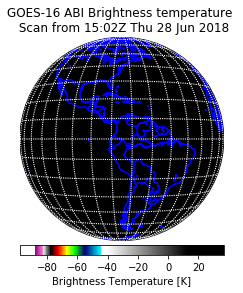

In [8]:
# Plot normal con proyección original
# plt.figure(figsize=(10,10))
bmap = Basemap(projection='geos', lon_0=-75, lat_0=0.0, satellite_height=35786023.0, ellps='GRS80', resolution='l')

# Plot GOES-16 Channel using 170 and 378 as the temperature thresholds
bmap.imshow(Ch1_rad, origin='upper', vmin=175-273.15, vmax=310-273.15, cmap=cpt_convert)
 
# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='blue')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='blue')
bmap.drawparallels(np.arange(-90.0, 90.0, 10.0), linewidth=1.1, color='white')
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=1.1, color='white')
 
# Insert the legend
bmap.colorbar(location='bottom', label='Brightness Temperature [K]')

date_formatted = datetime.strftime(datetime_start,
                                   '%H:%MZ %a %d %b %Y')
plt.title("GOES-16 ABI Brightness temperature \n Scan from " +date_formatted)

#Export result
# DPI = 300
# plt.savefig('GOES-16_Ch13.png', dpi=DPI, bbox_inches='tight', pad_inches=0)
 
# Show the plot
plt.rcParams['figure.figsize'] = (10,10)
plt.show()

In [ ]:
fig = plt.figure(figsize=(3,3),dpi=150)
im = plt.imshow(Ch1_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch1 "Blue" (0.47 µm)')
plt.show()

In [9]:
## Ch 2
Ch2_nc = Dataset(Ch2_pth)
Ch2_rad = Ch2_nc.variables['Rad'][:]
Ch2_nc.close()
Ch2_nc = None

In [ ]:
fig = plt.figure(figsize=(3,3),dpi=100)
im = plt.imshow(Ch2_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch2 "Red" (0.64 µm)')
plt.show()

In [10]:
# Ch 3
Ch3_nc = Dataset(Ch3_pth)
Ch3_rad = Ch3_nc.variables['Rad'][:]
Ch3_nc.close()
Ch3_nc = None

In [ ]:
fig = plt.figure(figsize=(3,3),dpi=100)
im = plt.imshow(Ch3_rad, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.title('Ch3 "Veggie" (0.86 µm)')
plt.show()

Se aplica un "rebin" para tener imágenes del mismo tamaño

In [ ]:
print("Ch1",np.shape(Ch1_rad))
print("Ch2",np.shape(Ch2_rad))
print("Ch3",np.shape(Ch3_rad))

In [11]:
Ch2_rad = rebin(Ch2_rad, [3000, 5000])

In [32]:
# Se obtiene reflectancia con la función de Olmo
Ch1_ref = reflectance(Ch1_rad, band=1)
Ch2_ref = reflectance(Ch2_rad, band=2)
Ch3_ref = reflectance(Ch3_rad, band=3)

#Se aplica la transformación gamma
Ch1_gamma = np.sqrt(Ch1_ref)
Ch2_gamma = np.sqrt(Ch2_ref)
Ch3_gamma = np.sqrt(Ch3_ref)

In [ ]:
# Dependiendo el equipo Se eliminan varios archivos para limpiar memoria
#del(Ch1_nc, Ch1_rad, Ch1_ref,Ch2_nc, Ch2_rad, Ch2_ref, Ch3_nc, Ch3_rad, Ch3_ref)

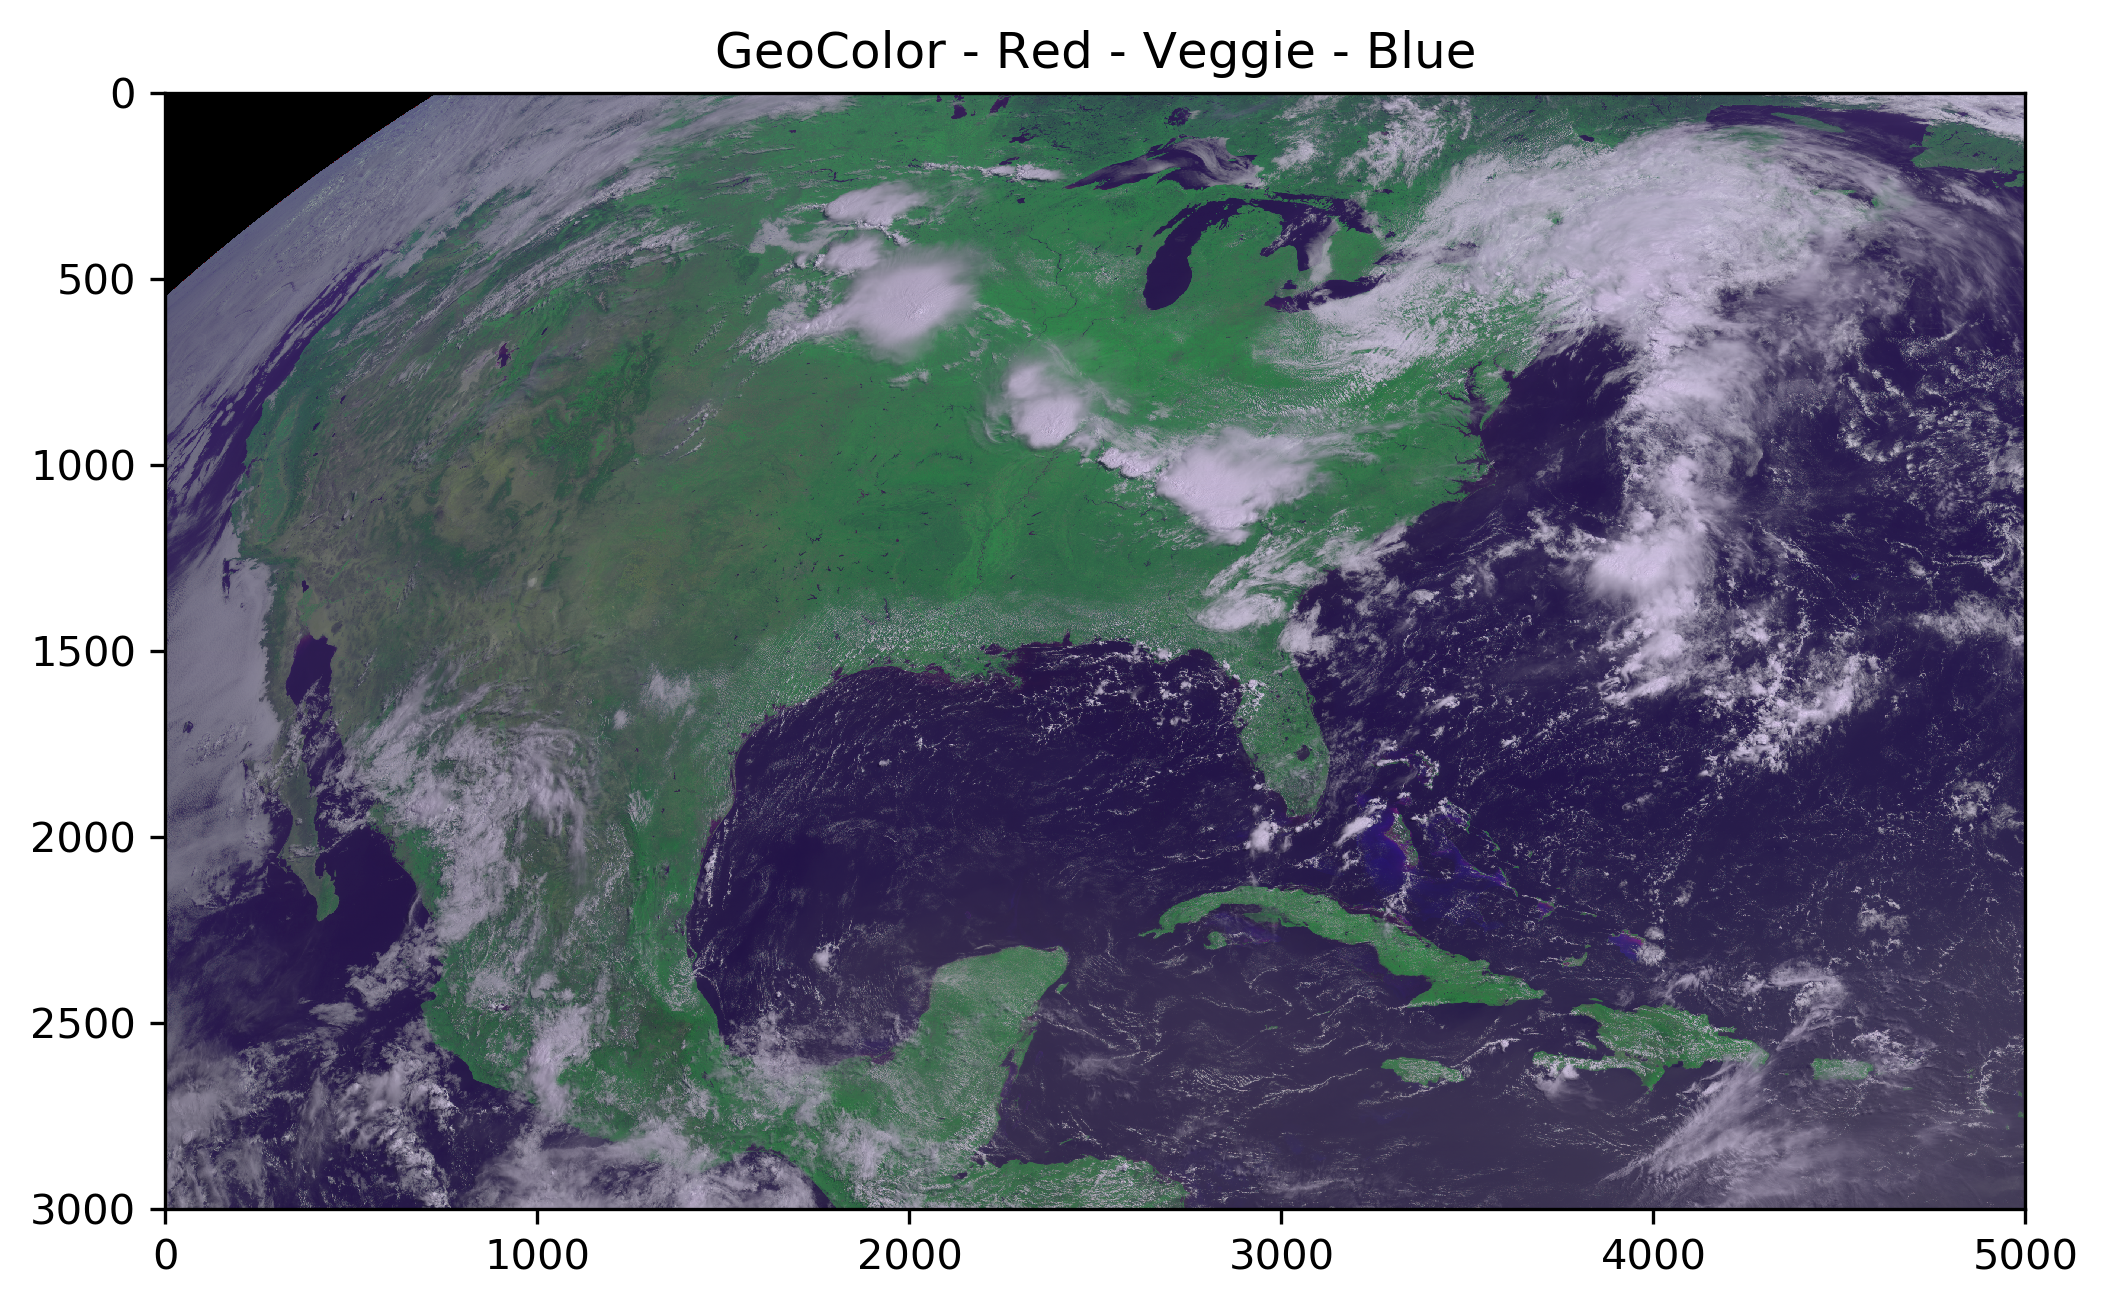

In [33]:
geocolor = np.stack([Ch2_gamma, Ch3_gamma, Ch1_gamma], axis=2)
fig = plt.figure(figsize=(8,8),dpi=300)
im = plt.imshow(geocolor)
plt.title('GeoColor - Red - Veggie - Blue')
plt.show()

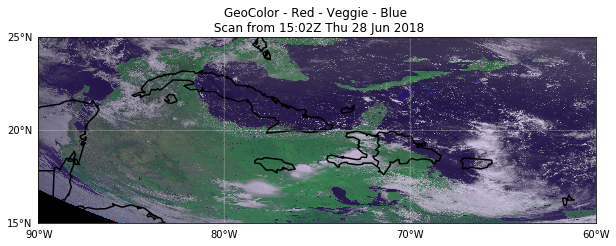

In [65]:
## ZOOM
# Create the basemap reference for the Satellite Projection
#plt.figure(figsize=(10,10))
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=25,  resolution='l')

#bmap.imshow(geocolor)
bmap.imshow(geocolor)

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=1.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

#im = plt.imshow(geocolor)
date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
plt.title("GeoColor - Red - Veggie - Blue \n Scan from " + date_formatted)


plt.show()

### ERROR!!!
La figura de arriba no corresponde a las latitudes ¿cómo le hago? 


## Nota extra
#### Esta cosa está bien chila para hacer mapas base para tesis, papers, etc!!

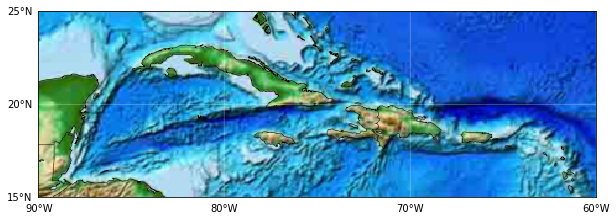

In [28]:

bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=25,  resolution='i')

bmap.etopo()
#bmap.contourf(lons,lats,geocolor, cmap=cpt_convert)
#bmap? = plt.imshow(geocolor)


# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

#im = plt.imshow(geocolor)
#date_formatted = datetime.strftime(datetime_start,'%H:%MZ %a %d %b %Y')
#plt.title("GeoColor - Red - Veggie - Blue \n Scan from " + date_formatted)


plt.show()

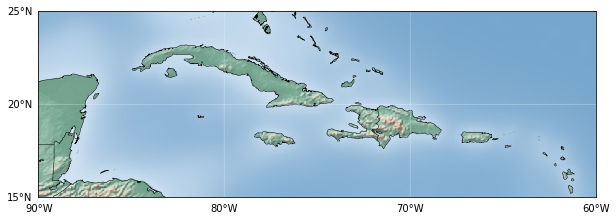

In [29]:
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=25,  resolution='i')

bmap.shadedrelief()

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

plt.show()

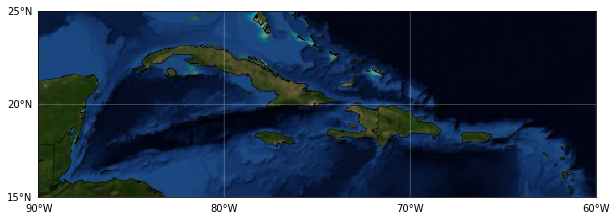

In [30]:
bmap = Basemap(projection='cyl', 
               llcrnrlon=-90, urcrnrlon=-60,
               llcrnrlat=15,   urcrnrlat=25,  resolution='i')

bmap.bluemarble()

# Draw the coastlines, countries, parallels and meridians
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='black')
bmap.drawcountries(linewidth=0.5, linestyle='solid', color='black')
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, color='white', labels=[True, False, False, True])
bmap.drawmeridians(np.arange(0.0, 360.0, 10.0), linewidth=0.5, color='white', labels=[True, False, False, True])

plt.show()